<a href="https://colab.research.google.com/github/DivyaNarayan0613/DivyaNarayan0613/blob/main/GenAI_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Check device (GPU recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


latent_dim = 100 - The generator learns to map this random noise to meaningful data. A latent_dim of 100 means the noise vector has 100 random values (features).


batch_size = 128 - A batch size of 128 means the model processes 128 samples at a time. Larger batch sizes can stabilize training but require more memory, while smaller batches are computationally lighter but may result in noisier updates.


lr = 0.0002 - A learning rate of 0.0002 indicates that the model takes small, cautious steps to optimize the weights. A value that's too high may cause the model to diverge, while a value that's too low may slow down convergence.


epochs = 50 - Training for 50 epochs means the model will loop through the dataset 50 times, refining its weights with each pass. The choice of the number of epochs depends on the complexity of the model and the dataset.

In [ ]:
# Define hyperparameters
latent_dim = 100    # Dimension of the noise vector
batch_size = 128    # Batch size
lr = 0.0002         # Learning rate
epochs = 50         # Number of epochs

Transformations are applied to the MNIST dataset before loading it into the model.

**transforms.Compose** is used to chain multiple transformations together.


Transformations applied:

    ToTensor(): Converts the images (which are PIL images or NumPy arrays) into PyTorch tensors and scales the pixel values to the range [0, 1].
    Normalize([0.5], [0.5]): Normalizes the pixel values to the range [-1, 1].
        The formula is:
        Normalized Value=(Value−Mean)/Std
       
            Mean = 0.5 and Std = 0.5.
            When applied, it maps the range [0, 1] (from ToTensor()) to [-1, 1].

Loads the MNIST dataset, which is a collection of 28x28 grayscale images of handwritten digits (0-9).

Parameters:

    root="./data": Specifies the directory where the dataset will be stored.
    train=True: Loads the training split of the dataset (not the test split).
    transform=transform: Applies the defined transformations (ToTensor and Normalize) to each image.
    download=True: Downloads the dataset if it's not already available in the root directory.

Wraps the MNIST dataset in a DataLoader, which helps efficiently manage data during training.

Parameters:

    mnist_data: The dataset to load.
    batch_size=batch_size: Specifies the number of samples per batch (from the earlier batch_size = 128).
    shuffle=True: Shuffles the dataset before creating batches to ensure randomness during training.


In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])
mnist_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)


NameError: name 'transforms' is not defined

This code defines a Generator model for a GAN (Generative Adversarial Network).
1. Class Definition - The Generator is a neural network that takes in a latent vector (z) sampled from a random distribution (like a Gaussian or uniform distribution) and generates synthetic data (e.g., MNIST images in this case).
The class inherits from nn.Module, which is the base class for PyTorch models.


2. __init__ Method

Input Layer:

    nn.Linear(latent_dim, 256)
        Takes the latent vector z of size latent_dim (e.g., 100) and maps it to a hidden layer with 256 neurons.


Hidden Layers:

    Each nn.Linear layer transforms the output of the previous layer into the next layer with more neurons:
        256 → 512 → 1024.
    Each layer is followed by a LeakyReLU activation:

Output Layer:

    nn.Linear(1024, 28 * 28)
        Maps the output to 784 units, which corresponds to the pixel count of a 28x28 grayscale image (used in MNIST).

    nn.Tanh()

    Normalizes the output to the range [-1, 1] (as the MNIST images are normalized to this range during preprocessing).

3. forward Method

The forward method defines how the input z (the latent vector) passes through the generator network.
self.model(z):

    Feeds z through the fully connected layers and activations defined in self.model.

.view(-1, 1, 28, 28):

    Reshapes the output from a 1D vector of size 784 to a 2D image of size (1, 28, 28):
        -1: Automatically infers the batch size.
        1: Indicates a single color channel (grayscale).
        28, 28: Image dimensions.

In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # Reshape to image size


This code defines a Discriminator model for a GAN (Generative Adversarial Network). The Discriminator’s job is to classify images as real (from the dataset) or fake (generated by the Generator)

Input:

    The Discriminator takes an image as input, which could be:
        A real image from the MNIST dataset.
        A fake image generated by the Generator.

Output:

    Produces a single value (probability) for each image:
        Closer to 1: The image is likely real.
        Closer to 0: The image is likely fake.

Training:

    The Discriminator learns to:
        Maximize the probability of correctly classifying real images as real.
        Minimize the probability of incorrectly classifying fake images as real.

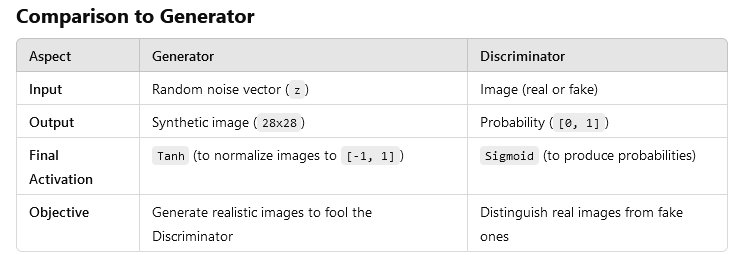

GANs involve a classification task for the Discriminator: distinguishing real images (label 1) from fake images (label 0).
The Generator also indirectly uses this loss because it tries to "fool" the Discriminator into classifying fake images as real (label 1).

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output between [0, 1]
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))  # Flatten image


In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# **Optimizer for the Generator**

optim.Adam:

    An adaptive gradient descent optimization algorithm.
    It combines the benefits of Momentum (fast convergence) and RMSProp (adaptive learning rate).

generator.parameters():

    Specifies that this optimizer will update the parameters of the Generator during backpropagation.

lr=lr:

    The learning rate (e.g., 0.0002) determines how large the parameter updates will be.

betas=(0.5, 0.999):

    These are the coefficients for computing running averages of gradients and squared gradients:
        beta1=0.5 reduces the oscillations caused by Momentum during GAN training.
        beta2=0.999 is a standard value for Adam.

# **Optimizer** **for** **the** **Discriminator**


Similar to optimizer_G, but this optimizer updates the parameters of the Discriminator.

In [ ]:
# Define loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


Train the Discriminator:

    Maximize its ability to classify real and fake images correctly.
    Loss: Combination of real and fake losses.

Train the Generator:

    Fool the Discriminator into classifying fake images as real.
    Loss: Fake images are compared with real labels.

Monitor Training:

    Print Discriminator and Generator losses periodically.
    Visualize generated images at the end of each epoch.

Completion:

    After all epochs are completed, the GAN training loop ends, and the Generator should have learned to produce realistic-looking images.

Epoch [1/50] Batch [0/469] Loss D: 1.3985, Loss G: 0.7016
Epoch [1/50] Batch [100/469] Loss D: 1.3244, Loss G: 1.3522
Epoch [1/50] Batch [200/469] Loss D: 0.6689, Loss G: 1.3206
Epoch [1/50] Batch [300/469] Loss D: 0.2125, Loss G: 4.1134
Epoch [1/50] Batch [400/469] Loss D: 0.3217, Loss G: 2.6130


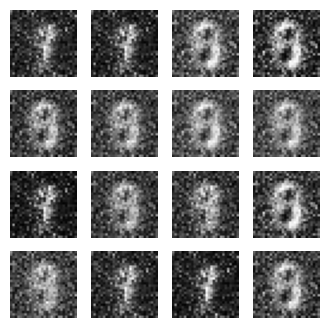

Epoch [2/50] Batch [0/469] Loss D: 0.3441, Loss G: 3.5074
Epoch [2/50] Batch [100/469] Loss D: 0.3021, Loss G: 3.2837
Epoch [2/50] Batch [200/469] Loss D: 0.2816, Loss G: 3.0591
Epoch [2/50] Batch [300/469] Loss D: 0.2051, Loss G: 3.0342
Epoch [2/50] Batch [400/469] Loss D: 0.2737, Loss G: 3.6567


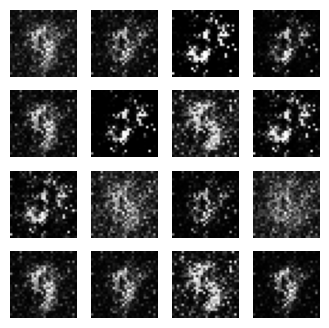

Epoch [3/50] Batch [0/469] Loss D: 0.2189, Loss G: 4.1285
Epoch [3/50] Batch [100/469] Loss D: 0.8127, Loss G: 3.7322
Epoch [3/50] Batch [200/469] Loss D: 0.6937, Loss G: 5.6744
Epoch [3/50] Batch [300/469] Loss D: 0.4079, Loss G: 2.8434
Epoch [3/50] Batch [400/469] Loss D: 0.1786, Loss G: 3.5290


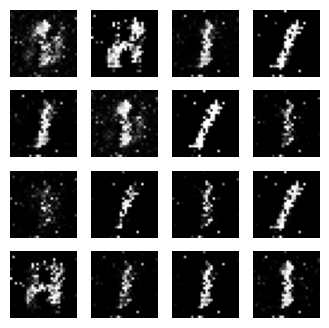

Epoch [4/50] Batch [0/469] Loss D: 0.2747, Loss G: 1.8955
Epoch [4/50] Batch [100/469] Loss D: 0.4251, Loss G: 2.3928
Epoch [4/50] Batch [200/469] Loss D: 0.3655, Loss G: 2.8105
Epoch [4/50] Batch [300/469] Loss D: 0.3492, Loss G: 2.4714
Epoch [4/50] Batch [400/469] Loss D: 0.3964, Loss G: 2.4395


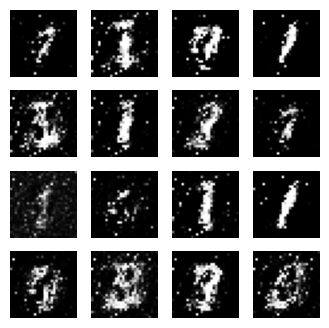

Epoch [5/50] Batch [0/469] Loss D: 0.3071, Loss G: 2.5872
Epoch [5/50] Batch [100/469] Loss D: 0.3808, Loss G: 3.5726
Epoch [5/50] Batch [200/469] Loss D: 0.5088, Loss G: 3.5444
Epoch [5/50] Batch [300/469] Loss D: 0.3247, Loss G: 2.4198
Epoch [5/50] Batch [400/469] Loss D: 0.4409, Loss G: 2.7307


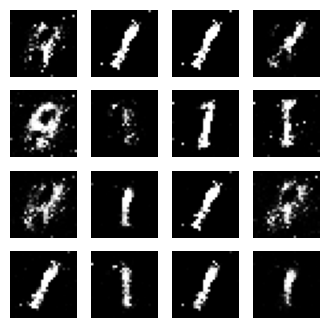

Epoch [6/50] Batch [0/469] Loss D: 0.4219, Loss G: 2.4287
Epoch [6/50] Batch [100/469] Loss D: 0.5174, Loss G: 2.0702
Epoch [6/50] Batch [200/469] Loss D: 0.3536, Loss G: 2.4355
Epoch [6/50] Batch [300/469] Loss D: 0.4016, Loss G: 2.3638
Epoch [6/50] Batch [400/469] Loss D: 0.6987, Loss G: 1.8959


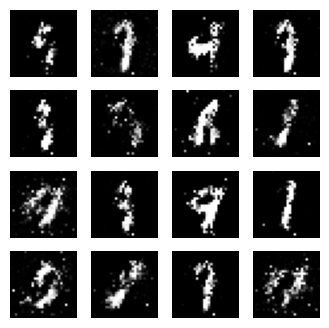

Epoch [7/50] Batch [0/469] Loss D: 0.4253, Loss G: 2.0297
Epoch [7/50] Batch [100/469] Loss D: 0.4292, Loss G: 2.6051
Epoch [7/50] Batch [200/469] Loss D: 0.7090, Loss G: 3.1740
Epoch [7/50] Batch [300/469] Loss D: 0.8862, Loss G: 1.3242
Epoch [7/50] Batch [400/469] Loss D: 0.5144, Loss G: 2.0139


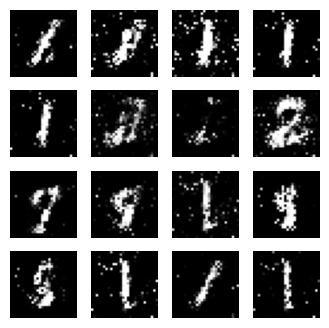

Epoch [8/50] Batch [0/469] Loss D: 0.7554, Loss G: 1.6434
Epoch [8/50] Batch [100/469] Loss D: 0.6734, Loss G: 3.1304
Epoch [8/50] Batch [200/469] Loss D: 0.5592, Loss G: 1.4727
Epoch [8/50] Batch [300/469] Loss D: 0.6883, Loss G: 1.3180
Epoch [8/50] Batch [400/469] Loss D: 0.9427, Loss G: 3.4058


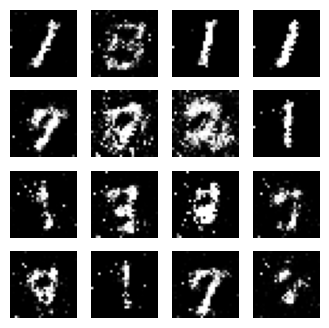

Epoch [9/50] Batch [0/469] Loss D: 0.7060, Loss G: 2.9760
Epoch [9/50] Batch [100/469] Loss D: 0.7705, Loss G: 2.1420
Epoch [9/50] Batch [200/469] Loss D: 0.5680, Loss G: 1.7449
Epoch [9/50] Batch [300/469] Loss D: 0.6615, Loss G: 1.8299
Epoch [9/50] Batch [400/469] Loss D: 0.7178, Loss G: 1.9200


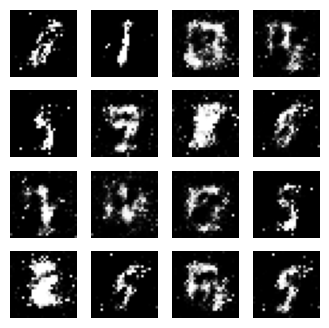

Epoch [10/50] Batch [0/469] Loss D: 0.9337, Loss G: 1.2309
Epoch [10/50] Batch [100/469] Loss D: 0.9431, Loss G: 2.6667
Epoch [10/50] Batch [200/469] Loss D: 0.8011, Loss G: 1.4734
Epoch [10/50] Batch [300/469] Loss D: 0.8615, Loss G: 1.4975
Epoch [10/50] Batch [400/469] Loss D: 0.9416, Loss G: 1.5328


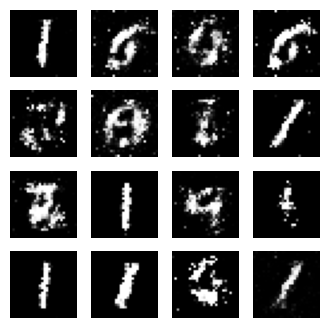

Epoch [11/50] Batch [0/469] Loss D: 0.8519, Loss G: 1.2368
Epoch [11/50] Batch [100/469] Loss D: 0.8391, Loss G: 2.2717
Epoch [11/50] Batch [200/469] Loss D: 0.8523, Loss G: 1.5026
Epoch [11/50] Batch [300/469] Loss D: 1.0389, Loss G: 2.0749
Epoch [11/50] Batch [400/469] Loss D: 0.9582, Loss G: 1.1619


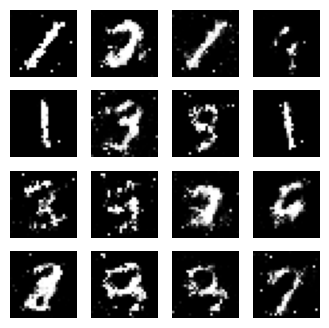

Epoch [12/50] Batch [0/469] Loss D: 0.9283, Loss G: 1.8802
Epoch [12/50] Batch [100/469] Loss D: 0.8036, Loss G: 1.5879
Epoch [12/50] Batch [200/469] Loss D: 0.8586, Loss G: 1.7700
Epoch [12/50] Batch [300/469] Loss D: 0.9302, Loss G: 1.1687
Epoch [12/50] Batch [400/469] Loss D: 1.0605, Loss G: 1.1314


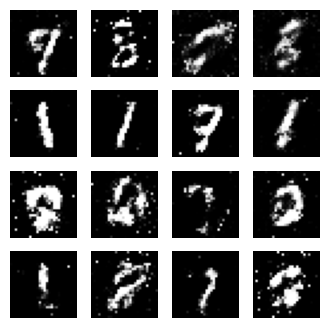

Epoch [13/50] Batch [0/469] Loss D: 0.9498, Loss G: 1.3655
Epoch [13/50] Batch [100/469] Loss D: 1.3133, Loss G: 0.6264
Epoch [13/50] Batch [200/469] Loss D: 0.7899, Loss G: 1.2444
Epoch [13/50] Batch [300/469] Loss D: 0.9708, Loss G: 1.1965
Epoch [13/50] Batch [400/469] Loss D: 0.7672, Loss G: 1.0937


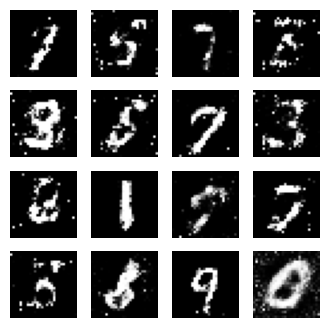

Epoch [14/50] Batch [0/469] Loss D: 0.9351, Loss G: 1.6761
Epoch [14/50] Batch [100/469] Loss D: 0.9163, Loss G: 1.3374
Epoch [14/50] Batch [200/469] Loss D: 0.8786, Loss G: 1.2896
Epoch [14/50] Batch [300/469] Loss D: 0.9600, Loss G: 1.3065
Epoch [14/50] Batch [400/469] Loss D: 1.1477, Loss G: 1.5808


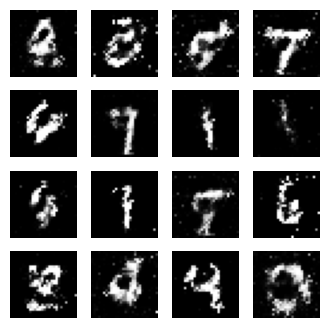

Epoch [15/50] Batch [0/469] Loss D: 1.2083, Loss G: 1.9798
Epoch [15/50] Batch [100/469] Loss D: 0.9677, Loss G: 1.4839
Epoch [15/50] Batch [200/469] Loss D: 0.9188, Loss G: 1.3984
Epoch [15/50] Batch [300/469] Loss D: 1.3710, Loss G: 0.9963
Epoch [15/50] Batch [400/469] Loss D: 1.0425, Loss G: 1.5633


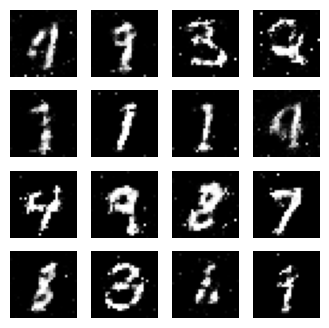

Epoch [16/50] Batch [0/469] Loss D: 0.9488, Loss G: 1.1489
Epoch [16/50] Batch [100/469] Loss D: 0.9210, Loss G: 1.2439
Epoch [16/50] Batch [200/469] Loss D: 1.0126, Loss G: 1.6304
Epoch [16/50] Batch [300/469] Loss D: 0.8928, Loss G: 1.5351
Epoch [16/50] Batch [400/469] Loss D: 1.0003, Loss G: 1.4357


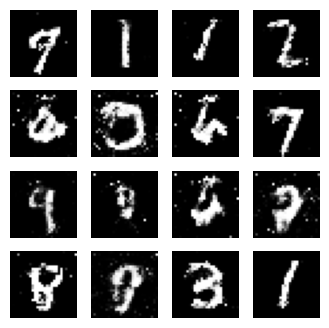

Epoch [17/50] Batch [0/469] Loss D: 1.1018, Loss G: 1.3375
Epoch [17/50] Batch [100/469] Loss D: 0.9986, Loss G: 1.3733
Epoch [17/50] Batch [200/469] Loss D: 0.9254, Loss G: 1.1189
Epoch [17/50] Batch [300/469] Loss D: 0.9493, Loss G: 1.4006
Epoch [17/50] Batch [400/469] Loss D: 0.9824, Loss G: 1.4262


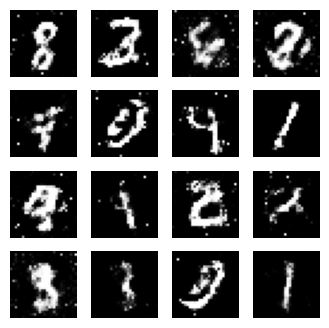

Epoch [18/50] Batch [0/469] Loss D: 0.9396, Loss G: 1.8225
Epoch [18/50] Batch [100/469] Loss D: 1.1139, Loss G: 1.1129
Epoch [18/50] Batch [200/469] Loss D: 1.1567, Loss G: 0.9081
Epoch [18/50] Batch [300/469] Loss D: 1.0995, Loss G: 1.3086
Epoch [18/50] Batch [400/469] Loss D: 1.0676, Loss G: 1.1076


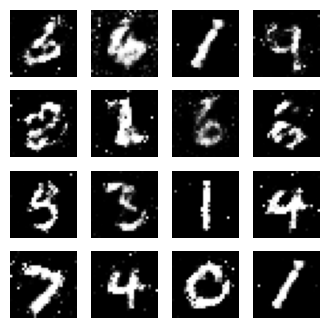

Epoch [19/50] Batch [0/469] Loss D: 1.0357, Loss G: 1.0268
Epoch [19/50] Batch [100/469] Loss D: 1.0425, Loss G: 1.4225
Epoch [19/50] Batch [200/469] Loss D: 0.9851, Loss G: 1.7241
Epoch [19/50] Batch [300/469] Loss D: 1.0164, Loss G: 1.2567
Epoch [19/50] Batch [400/469] Loss D: 1.0122, Loss G: 1.1498


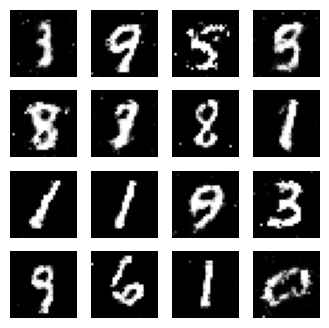

Epoch [20/50] Batch [0/469] Loss D: 1.2344, Loss G: 1.0488
Epoch [20/50] Batch [100/469] Loss D: 1.1548, Loss G: 1.3111
Epoch [20/50] Batch [200/469] Loss D: 1.1917, Loss G: 1.4116
Epoch [20/50] Batch [300/469] Loss D: 0.9994, Loss G: 1.2680
Epoch [20/50] Batch [400/469] Loss D: 1.0073, Loss G: 1.4117


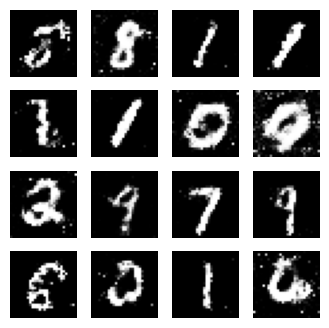

Epoch [21/50] Batch [0/469] Loss D: 1.0585, Loss G: 1.0503
Epoch [21/50] Batch [100/469] Loss D: 1.1151, Loss G: 1.0935
Epoch [21/50] Batch [200/469] Loss D: 1.1205, Loss G: 1.1714
Epoch [21/50] Batch [300/469] Loss D: 1.0491, Loss G: 1.2069
Epoch [21/50] Batch [400/469] Loss D: 1.2200, Loss G: 1.2384


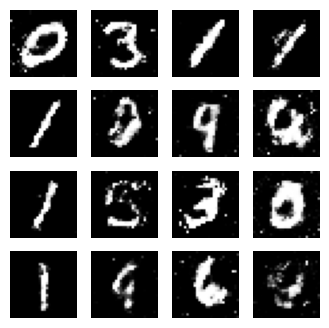

Epoch [22/50] Batch [0/469] Loss D: 1.0049, Loss G: 1.1806
Epoch [22/50] Batch [100/469] Loss D: 0.9994, Loss G: 1.2155
Epoch [22/50] Batch [200/469] Loss D: 1.0869, Loss G: 1.2554
Epoch [22/50] Batch [300/469] Loss D: 1.0269, Loss G: 1.0136
Epoch [22/50] Batch [400/469] Loss D: 1.0109, Loss G: 1.4395


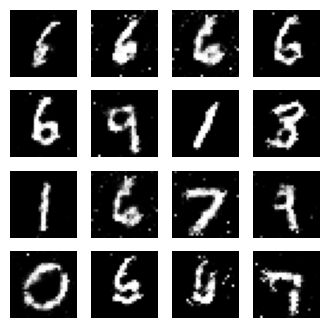

Epoch [23/50] Batch [0/469] Loss D: 1.0099, Loss G: 1.4104
Epoch [23/50] Batch [100/469] Loss D: 1.0438, Loss G: 1.3829
Epoch [23/50] Batch [200/469] Loss D: 1.0730, Loss G: 1.2591
Epoch [23/50] Batch [300/469] Loss D: 1.1018, Loss G: 1.3227
Epoch [23/50] Batch [400/469] Loss D: 1.2004, Loss G: 1.4786


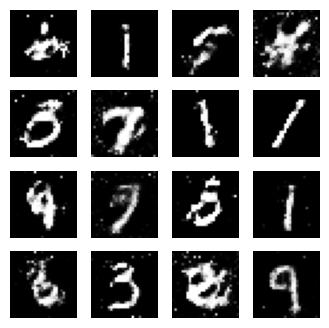

Epoch [24/50] Batch [0/469] Loss D: 1.1030, Loss G: 0.9868
Epoch [24/50] Batch [100/469] Loss D: 1.0824, Loss G: 0.9441
Epoch [24/50] Batch [200/469] Loss D: 0.9934, Loss G: 1.2028
Epoch [24/50] Batch [300/469] Loss D: 1.1408, Loss G: 1.0656
Epoch [24/50] Batch [400/469] Loss D: 1.0660, Loss G: 1.0906


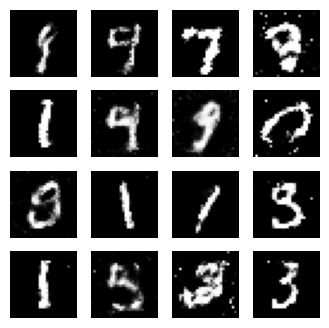

Epoch [25/50] Batch [0/469] Loss D: 1.0770, Loss G: 1.3649
Epoch [25/50] Batch [100/469] Loss D: 1.0971, Loss G: 1.0077
Epoch [25/50] Batch [200/469] Loss D: 1.0583, Loss G: 1.0363
Epoch [25/50] Batch [300/469] Loss D: 1.1906, Loss G: 1.1210
Epoch [25/50] Batch [400/469] Loss D: 1.1403, Loss G: 1.1555


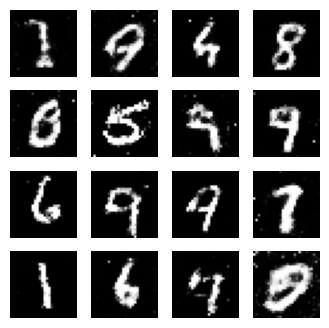

Epoch [26/50] Batch [0/469] Loss D: 1.1024, Loss G: 1.2539
Epoch [26/50] Batch [100/469] Loss D: 1.0972, Loss G: 1.0336
Epoch [26/50] Batch [200/469] Loss D: 1.1779, Loss G: 0.9016
Epoch [26/50] Batch [300/469] Loss D: 1.0123, Loss G: 1.3288
Epoch [26/50] Batch [400/469] Loss D: 1.0678, Loss G: 1.2475


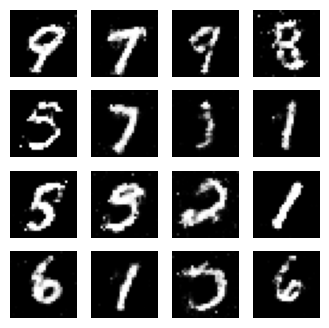

Epoch [27/50] Batch [0/469] Loss D: 1.0880, Loss G: 1.4928
Epoch [27/50] Batch [100/469] Loss D: 1.0185, Loss G: 1.0996
Epoch [27/50] Batch [200/469] Loss D: 1.1054, Loss G: 1.3100
Epoch [27/50] Batch [300/469] Loss D: 1.0442, Loss G: 1.3630
Epoch [27/50] Batch [400/469] Loss D: 1.1399, Loss G: 1.2171


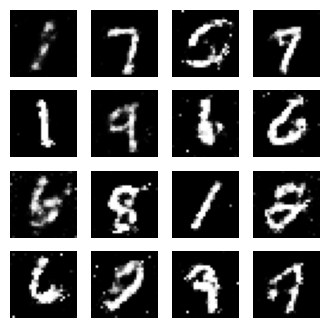

Epoch [28/50] Batch [0/469] Loss D: 1.0339, Loss G: 1.2421
Epoch [28/50] Batch [100/469] Loss D: 1.0474, Loss G: 1.3752
Epoch [28/50] Batch [200/469] Loss D: 1.1411, Loss G: 1.1814
Epoch [28/50] Batch [300/469] Loss D: 1.0230, Loss G: 1.3476
Epoch [28/50] Batch [400/469] Loss D: 1.0801, Loss G: 1.1771


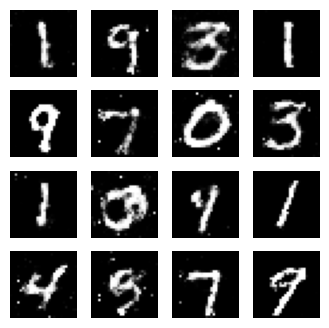

Epoch [29/50] Batch [0/469] Loss D: 1.0222, Loss G: 1.0960
Epoch [29/50] Batch [100/469] Loss D: 1.0802, Loss G: 1.2579
Epoch [29/50] Batch [200/469] Loss D: 0.9622, Loss G: 1.1266
Epoch [29/50] Batch [300/469] Loss D: 1.1275, Loss G: 1.0026
Epoch [29/50] Batch [400/469] Loss D: 1.0396, Loss G: 1.0440


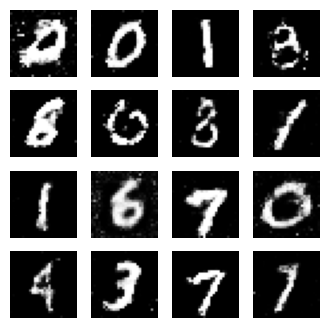

Epoch [30/50] Batch [0/469] Loss D: 1.1754, Loss G: 1.1617
Epoch [30/50] Batch [100/469] Loss D: 1.0499, Loss G: 1.4911
Epoch [30/50] Batch [200/469] Loss D: 1.1134, Loss G: 1.0353
Epoch [30/50] Batch [300/469] Loss D: 1.0230, Loss G: 1.0973
Epoch [30/50] Batch [400/469] Loss D: 1.1747, Loss G: 1.1307


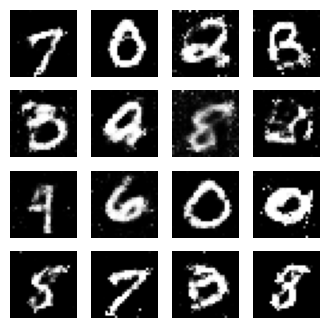

Epoch [31/50] Batch [0/469] Loss D: 1.1328, Loss G: 1.0289
Epoch [31/50] Batch [100/469] Loss D: 1.1438, Loss G: 1.1798
Epoch [31/50] Batch [200/469] Loss D: 1.0779, Loss G: 1.2697
Epoch [31/50] Batch [300/469] Loss D: 1.0856, Loss G: 1.1387
Epoch [31/50] Batch [400/469] Loss D: 1.0155, Loss G: 1.1318


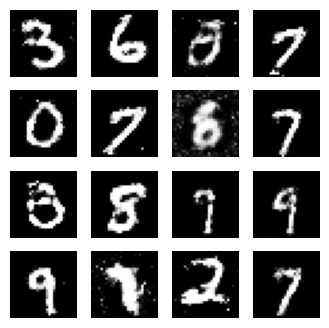

Epoch [32/50] Batch [0/469] Loss D: 1.0617, Loss G: 0.9069
Epoch [32/50] Batch [100/469] Loss D: 1.1021, Loss G: 1.1658
Epoch [32/50] Batch [200/469] Loss D: 1.1894, Loss G: 1.3256
Epoch [32/50] Batch [300/469] Loss D: 1.1168, Loss G: 1.3339
Epoch [32/50] Batch [400/469] Loss D: 1.1201, Loss G: 0.9613


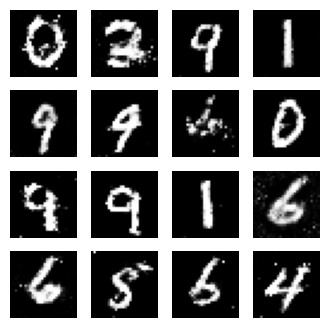

Epoch [33/50] Batch [0/469] Loss D: 1.0854, Loss G: 1.1224
Epoch [33/50] Batch [100/469] Loss D: 1.0633, Loss G: 1.5137
Epoch [33/50] Batch [200/469] Loss D: 1.1533, Loss G: 1.2911
Epoch [33/50] Batch [300/469] Loss D: 1.0905, Loss G: 1.2519
Epoch [33/50] Batch [400/469] Loss D: 1.2115, Loss G: 1.2424


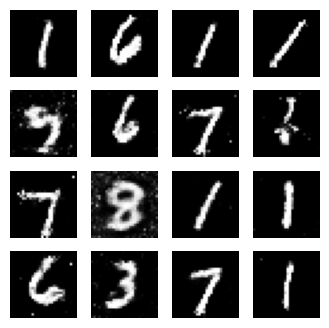

Epoch [34/50] Batch [0/469] Loss D: 1.1350, Loss G: 1.1943
Epoch [34/50] Batch [100/469] Loss D: 1.1278, Loss G: 1.3210
Epoch [34/50] Batch [200/469] Loss D: 1.1979, Loss G: 1.0913
Epoch [34/50] Batch [300/469] Loss D: 1.1139, Loss G: 1.2842
Epoch [34/50] Batch [400/469] Loss D: 1.1183, Loss G: 1.0164


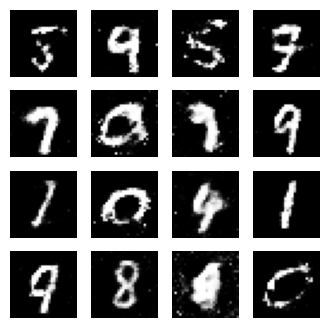

Epoch [35/50] Batch [0/469] Loss D: 1.1840, Loss G: 1.6259
Epoch [35/50] Batch [100/469] Loss D: 1.1011, Loss G: 1.1215
Epoch [35/50] Batch [200/469] Loss D: 1.1312, Loss G: 1.1065
Epoch [35/50] Batch [300/469] Loss D: 1.1634, Loss G: 1.0817
Epoch [35/50] Batch [400/469] Loss D: 0.9957, Loss G: 1.2247


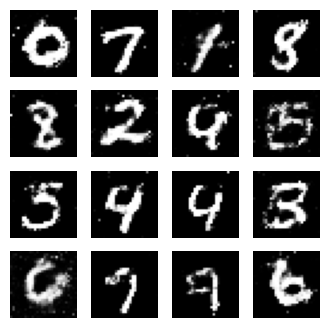

Epoch [36/50] Batch [0/469] Loss D: 1.1521, Loss G: 1.1583
Epoch [36/50] Batch [100/469] Loss D: 1.0862, Loss G: 1.3467
Epoch [36/50] Batch [200/469] Loss D: 1.0814, Loss G: 1.1178
Epoch [36/50] Batch [300/469] Loss D: 1.2467, Loss G: 1.0465
Epoch [36/50] Batch [400/469] Loss D: 1.0562, Loss G: 1.3833


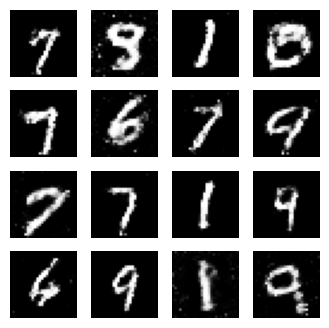

Epoch [37/50] Batch [0/469] Loss D: 1.1566, Loss G: 1.1084
Epoch [37/50] Batch [100/469] Loss D: 1.1727, Loss G: 0.8757
Epoch [37/50] Batch [200/469] Loss D: 1.0348, Loss G: 1.0626
Epoch [37/50] Batch [300/469] Loss D: 1.0487, Loss G: 1.3909
Epoch [37/50] Batch [400/469] Loss D: 1.1353, Loss G: 1.1142


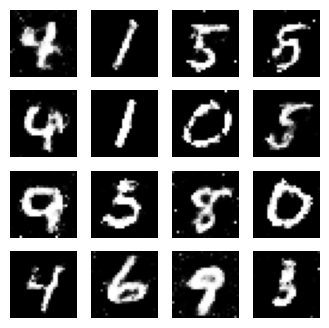

Epoch [38/50] Batch [0/469] Loss D: 1.0822, Loss G: 1.0934
Epoch [38/50] Batch [100/469] Loss D: 1.0458, Loss G: 1.2444
Epoch [38/50] Batch [200/469] Loss D: 1.1236, Loss G: 0.9812
Epoch [38/50] Batch [300/469] Loss D: 0.9659, Loss G: 1.2941
Epoch [38/50] Batch [400/469] Loss D: 1.0863, Loss G: 1.3008


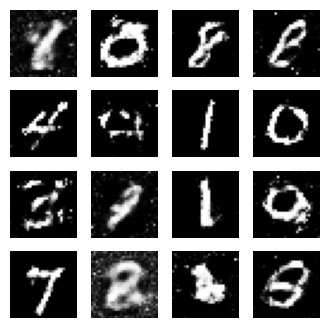

Epoch [39/50] Batch [0/469] Loss D: 1.1579, Loss G: 1.1326
Epoch [39/50] Batch [100/469] Loss D: 1.0246, Loss G: 0.9608
Epoch [39/50] Batch [200/469] Loss D: 1.0590, Loss G: 1.1564
Epoch [39/50] Batch [300/469] Loss D: 1.2286, Loss G: 0.9382
Epoch [39/50] Batch [400/469] Loss D: 1.1124, Loss G: 1.2857


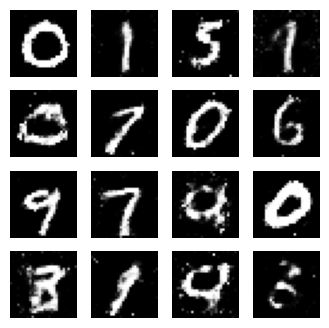

Epoch [40/50] Batch [0/469] Loss D: 1.1679, Loss G: 1.3406
Epoch [40/50] Batch [100/469] Loss D: 1.0687, Loss G: 1.1327
Epoch [40/50] Batch [200/469] Loss D: 1.1047, Loss G: 1.1672
Epoch [40/50] Batch [300/469] Loss D: 1.0733, Loss G: 1.1047
Epoch [40/50] Batch [400/469] Loss D: 1.2192, Loss G: 0.9168


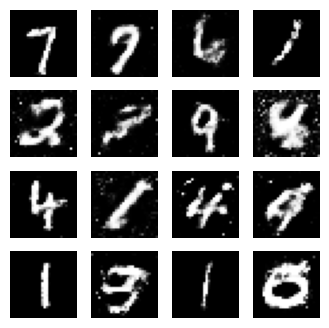

Epoch [41/50] Batch [0/469] Loss D: 1.0975, Loss G: 1.2644
Epoch [41/50] Batch [100/469] Loss D: 1.0771, Loss G: 1.4298
Epoch [41/50] Batch [200/469] Loss D: 1.1890, Loss G: 1.3316
Epoch [41/50] Batch [300/469] Loss D: 1.0119, Loss G: 1.1883
Epoch [41/50] Batch [400/469] Loss D: 1.2129, Loss G: 0.8938


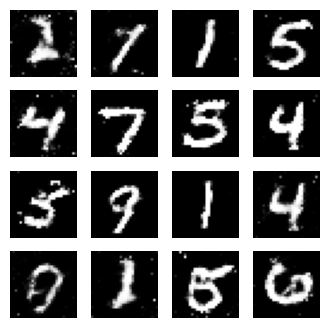

Epoch [42/50] Batch [0/469] Loss D: 1.1263, Loss G: 1.1191
Epoch [42/50] Batch [100/469] Loss D: 1.1913, Loss G: 1.2099
Epoch [42/50] Batch [200/469] Loss D: 1.0970, Loss G: 1.0464
Epoch [42/50] Batch [300/469] Loss D: 1.0864, Loss G: 1.0417
Epoch [42/50] Batch [400/469] Loss D: 1.1534, Loss G: 1.0494


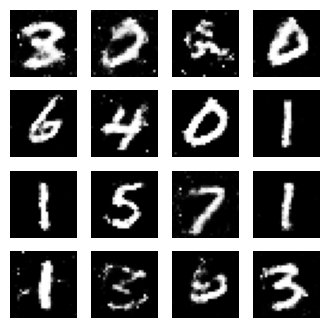

Epoch [43/50] Batch [0/469] Loss D: 1.1273, Loss G: 0.8800
Epoch [43/50] Batch [100/469] Loss D: 1.1165, Loss G: 1.0358
Epoch [43/50] Batch [200/469] Loss D: 1.1913, Loss G: 1.0954
Epoch [43/50] Batch [300/469] Loss D: 1.1207, Loss G: 1.4500
Epoch [43/50] Batch [400/469] Loss D: 1.0940, Loss G: 1.1349


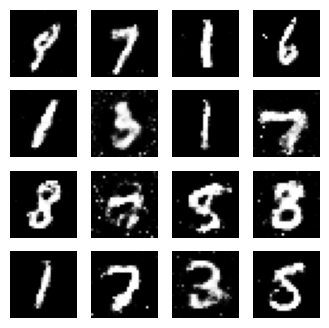

Epoch [44/50] Batch [0/469] Loss D: 1.1989, Loss G: 0.9020
Epoch [44/50] Batch [100/469] Loss D: 1.0587, Loss G: 1.0023
Epoch [44/50] Batch [200/469] Loss D: 1.1407, Loss G: 1.3010
Epoch [44/50] Batch [300/469] Loss D: 1.0028, Loss G: 1.1970
Epoch [44/50] Batch [400/469] Loss D: 1.0710, Loss G: 1.2225


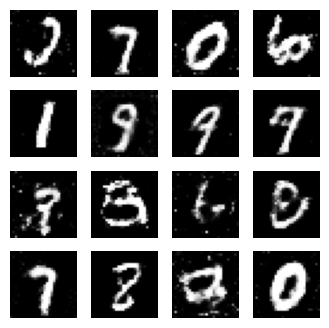

Epoch [45/50] Batch [0/469] Loss D: 1.1543, Loss G: 1.0203
Epoch [45/50] Batch [100/469] Loss D: 1.2878, Loss G: 0.8438
Epoch [45/50] Batch [200/469] Loss D: 1.1001, Loss G: 1.2207
Epoch [45/50] Batch [300/469] Loss D: 1.1516, Loss G: 1.1005
Epoch [45/50] Batch [400/469] Loss D: 1.0973, Loss G: 0.9814


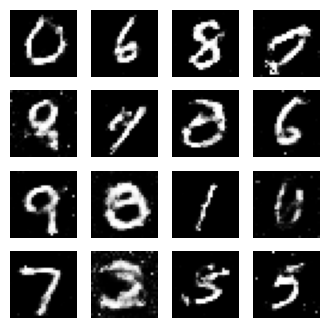

Epoch [46/50] Batch [0/469] Loss D: 1.0725, Loss G: 1.0702
Epoch [46/50] Batch [100/469] Loss D: 1.2342, Loss G: 1.2306
Epoch [46/50] Batch [200/469] Loss D: 1.0941, Loss G: 1.0107
Epoch [46/50] Batch [300/469] Loss D: 1.1438, Loss G: 0.8230
Epoch [46/50] Batch [400/469] Loss D: 1.1092, Loss G: 1.0965


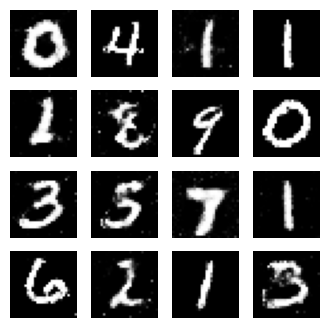

Epoch [47/50] Batch [0/469] Loss D: 1.0080, Loss G: 1.4321
Epoch [47/50] Batch [100/469] Loss D: 1.1429, Loss G: 1.0283
Epoch [47/50] Batch [200/469] Loss D: 1.1634, Loss G: 1.0367
Epoch [47/50] Batch [300/469] Loss D: 1.0457, Loss G: 1.3938
Epoch [47/50] Batch [400/469] Loss D: 1.0880, Loss G: 1.1542


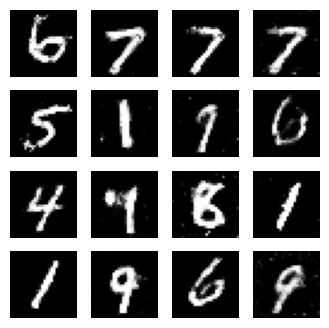

Epoch [48/50] Batch [0/469] Loss D: 1.0676, Loss G: 1.3028
Epoch [48/50] Batch [100/469] Loss D: 1.1202, Loss G: 1.2663
Epoch [48/50] Batch [200/469] Loss D: 1.0827, Loss G: 1.1129
Epoch [48/50] Batch [300/469] Loss D: 1.0573, Loss G: 1.2573
Epoch [48/50] Batch [400/469] Loss D: 1.0794, Loss G: 1.1010


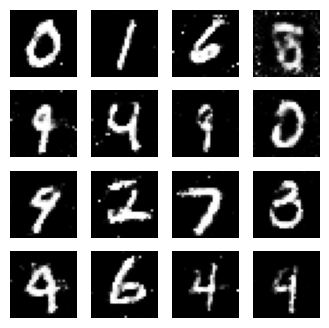

Epoch [49/50] Batch [0/469] Loss D: 1.1519, Loss G: 1.0403
Epoch [49/50] Batch [100/469] Loss D: 1.1135, Loss G: 1.4763
Epoch [49/50] Batch [200/469] Loss D: 1.2368, Loss G: 1.3645
Epoch [49/50] Batch [300/469] Loss D: 1.0984, Loss G: 1.0117
Epoch [49/50] Batch [400/469] Loss D: 1.2064, Loss G: 1.0514


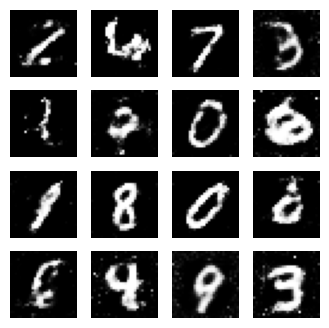

Epoch [50/50] Batch [0/469] Loss D: 1.0479, Loss G: 1.3712
Epoch [50/50] Batch [100/469] Loss D: 1.1259, Loss G: 1.2423
Epoch [50/50] Batch [200/469] Loss D: 1.1665, Loss G: 1.1337
Epoch [50/50] Batch [300/469] Loss D: 1.1602, Loss G: 1.3908
Epoch [50/50] Batch [400/469] Loss D: 1.1792, Loss G: 1.1034


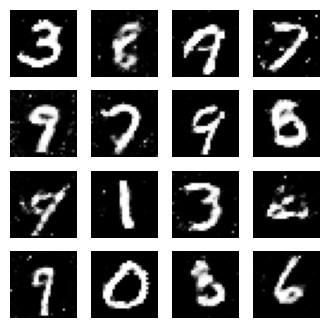

Training complete!


In [ ]:
# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(data_loader):
        # Real and fake labels
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Train Discriminator
        real_imgs = imgs.to(device)
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)  # Trick discriminator
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] Batch [{i}/{len(data_loader)}] "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    # Save some generated images after every epoch
    z = torch.randn(16, latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]

    # Plot and save generated images
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[i * 4 + j].squeeze(), cmap="gray")
            axs[i, j].axis("off")
    plt.show()

print("Training complete!")